In [7]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import ktrain
from ktrain import text


In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_len = len(train)
test_len = len(test)
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

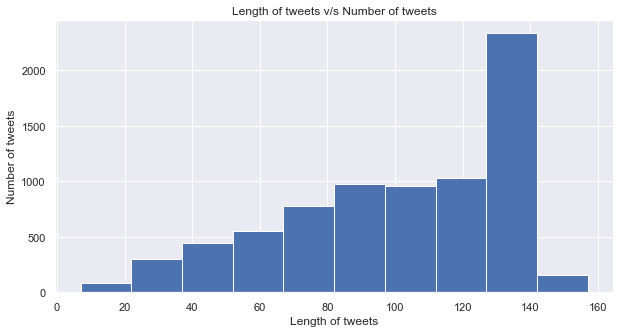

In [10]:
plt.figure(figsize=(10,5))
word_len = train['text'].map(lambda x: len(x))
plt.hist(word_len)
plt.xlabel('Length of tweets')
plt.ylabel('Number of tweets')
plt.title('Length of tweets v/s Number of tweets')
plt.show()

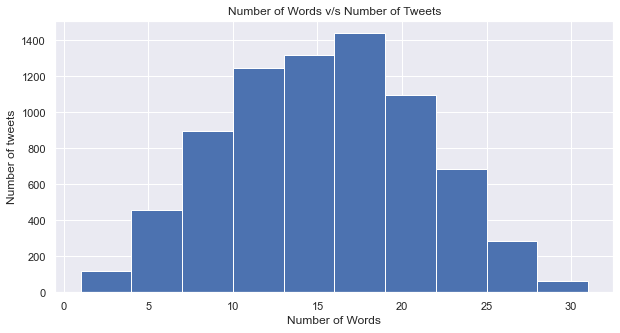

In [11]:
plt.figure(figsize=(10,5))
word_len = train['text'].str.split().map(lambda x: len(x))
plt.hist(word_len)
plt.xlabel('Number of Words')
plt.ylabel('Number of tweets')
plt.title('Number of Words v/s Number of Tweets')
plt.show()

In [12]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [13]:
train['keyword'].fillna('',inplace=True)
train['text'] = train['text'] + ' ' + train['keyword']
train['text'] = train['text'].apply(lambda x: x.strip())
train.drop(['keyword'],axis=1,inplace=True)
train.drop(['location'],axis=1,inplace=True)
train.head()


,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
test['keyword'].fillna('',inplace=True)
test['text'] = test['text'] + ' ' + test['keyword']
test['text'] = test['text'].apply(lambda x: x.strip())
test.drop(['keyword'],axis=1,inplace=True)
test.drop(['location'],axis=1,inplace=True)
test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [15]:
duplicate_records = train[train.duplicated(['text','target'],keep=False)] # Duplicate records with same targets.
print('Records having same text and targets:',len(duplicate_records))
duplicate_records.head()

Records having same text and targets: 117


,id,text,target
40,59,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
48,68,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
106,156,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
115,165,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
118,171,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0


In [16]:
train.drop_duplicates(['text','target'],inplace=True) # Dropping the duplicate records having same targets.

In [17]:
contradicting_records = train[train.duplicated(['text'],keep=False)] # Duplicate records with outliers.
print('Records having same text but different targets:',len(contradicting_records))
contradicting_records.head()

Records having same text but different targets: 30


,id,text,target
610,881,To fight bioterrorism sir. bioterrorism,1
624,898,To fight bioterrorism sir. bioterrorism,0
2830,4068,.POTUS #StrategicPatience is a strategy for #G...,1
2832,4076,.POTUS #StrategicPatience is a strategy for #G...,0
3240,4656,He came to a land which was engulfed in tribal...,0


In [18]:
records_to_drop = [610,2832,3243,3985,4244,4232,4292,4305,4306,4312,4320,4381,4618,5620,6091,6616] # Outliers.

train.drop(records_to_drop,inplace=True) # Dropping the outliers.
train = train.reset_index(drop=True) # Resetting the indexes.
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
stop_words = stopwords.words("english")
stemmer = PorterStemmer()

pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

def remove_html(text):
    no_html= pattern.sub('',text)
    return no_html

train['text']=train['text'].apply(lambda x : remove_html(x))
test['text']=test['text'].apply(lambda x : remove_html(x))
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
def clean(tweet):
    
    text = re.sub('[^a-zA-Z]', ' ', tweet)  

    text = text.lower()  

    # split to array(default delimiter is " ") 
    text = text.split()  
    
    text = [w for w in text if not w in set(stopwords.words('english'))] 

    text = ' '.join(text)    
            
    return text

train['text'] = train['text'].apply(clean)
test['text'] =test['text'].apply(clean)
train.head()

,id,text,target
0,1,deeds reason earthquake may allah forgive us,1
1,4,forest fire near la ronge sask canada,1
2,5,residents asked shelter place notified officer...,1
3,6,people receive wildfires evacuation orders cal...,1
4,7,got sent photo ruby alaska smoke wildfires pou...,1


In [15]:
data = pd.concat([train,test],axis=0,sort=False)
data.drop(['target'],axis=1,inplace=True)
data.head()

,id,text
0,1,deeds reason earthquake may allah forgive us
1,4,forest fire near la ronge sask canada
2,5,residents asked shelter place notified officer...
3,6,people receive wildfires evacuation orders cal...
4,7,got sent photo ruby alaska smoke wildfires pou...


In [16]:
tt = TweetTokenizer()
data['tokens'] = data['text'].apply(lambda x: tt.tokenize(x))
data.head()

,id,text,tokens
0,1,deeds reason earthquake may allah forgive us,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,residents asked shelter place notified officer...,"[residents, asked, shelter, place, notified, o..."
3,6,people receive wildfires evacuation orders cal...,"[people, receive, wildfires, evacuation, order..."
4,7,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


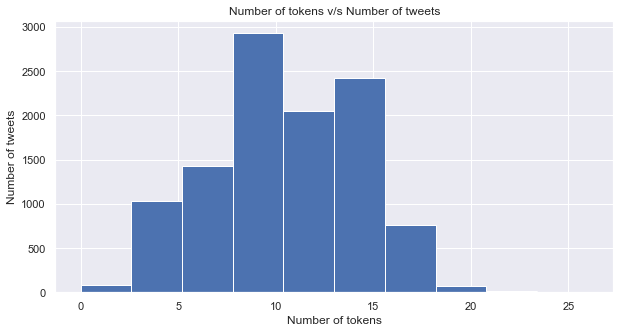

In [17]:
plt.figure(figsize=(10,5))
word_len = data['tokens'].map(lambda x: len(x))
plt.hist(word_len)
plt.xlabel('Number of tokens')
plt.ylabel('Number of tweets')
plt.title('Number of tokens v/s Number of tweets')
plt.show()

In [18]:
glove_vec_file = open('glove.6B.300d.txt')
embeddings = {}
for line in glove_vec_file:
    values = line.split()
    word = values[0]
    embedding = np.array(values[1:])
    embeddings[word] = embedding
glove_vec_file.close()

In [20]:
def embeddings_out(data, maxlen=20):
    output = np.zeros((data.shape[0],20,300))
    for ix in range(len(data)):
        curr_len = min(maxlen, maxlen,len(data.iloc[ix]['tokens']))
        for jx in range(curr_len):
            word = str(data.iloc[ix]['tokens'][jx])
            if word in embeddings:
                output[ix][jx] = embeddings[data.iloc[ix]['tokens'][jx]]
    return output

In [21]:
X = embeddings_out(data)
X.shape

(10788, 20, 300)

In [22]:
X_train = X[:len(train)]
X_test = X[len(train):]
y_train = train['target'].values
len(X_train), len(X_test), len(y_train)

(7525, 3263, 7525)

## Model Creation

In [23]:
def create_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64,input_shape=(X.shape[1],X.shape[2]),return_sequences=True))
    model.add(LSTM(64,input_shape=(X.shape[1],X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dropout(0.1))
    model.add(Activation('softmax'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [24]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 64)            93440     
_________________________________________________________________
dropout (Dropout)            (None, 20, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 64)            33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [25]:
#I would be using early stopping callback and would use 1/10th of the training data as validation to estimate the optimum number of epochs taht would prvent overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
hist = model.fit(X_train, y_train, epochs=100, batch_size=64, shuffle=True, validation_split=0.1, callbacks=[early_stop])

Epoch 1/100
106/106 [==============================] - 9s 42ms/step - loss: 0.6681 - accuracy: 0.6463 - val_loss: 0.5960 - val_accuracy: 0.7888
Epoch 2/100
106/106 [==============================] - 3s 28ms/step - loss: 0.5861 - accuracy: 0.7891 - val_loss: 0.5671 - val_accuracy: 0.7995
Epoch 3/100
106/106 [==============================] - 3s 30ms/step - loss: 0.5556 - accuracy: 0.8070 - val_loss: 0.5477 - val_accuracy: 0.7968
Epoch 4/100
106/106 [==============================] - 3s 30ms/step - loss: 0.5319 - accuracy: 0.8141 - val_loss: 0.5316 - val_accuracy: 0.8127
Epoch 5/100
106/106 [==============================] - 3s 30ms/step - loss: 0.5099 - accuracy: 0.8220 - val_loss: 0.5233 - val_accuracy: 0.8061
Epoch 6/100
106/106 [==============================] - 3s 29ms/step - loss: 0.4834 - accuracy: 0.8449 - val_loss: 0.5101 - val_accuracy: 0.8035
Epoch 7/100
106/106 [==============================] - 3s 32ms/step - loss: 0.4693 - accuracy: 0.8448 - val_loss: 0.5099 - val_accuracy:

<AxesSubplot:>

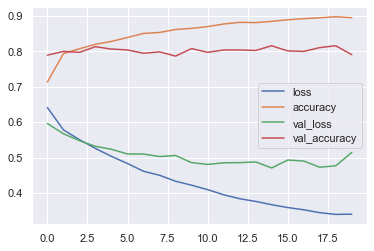

In [26]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [27]:
model = create_model()

In [28]:
history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=20, shuffle=True)

Epoch 1/20
118/118 [==============================] - 7s 28ms/step - loss: 0.6703 - accuracy: 0.6325
Epoch 2/20
118/118 [==============================] - 3s 27ms/step - loss: 0.6244 - accuracy: 0.7082
Epoch 3/20
118/118 [==============================] - 3s 29ms/step - loss: 0.5791 - accuracy: 0.7840
Epoch 4/20
118/118 [==============================] - 3s 28ms/step - loss: 0.5627 - accuracy: 0.7871
Epoch 5/20
118/118 [==============================] - 3s 27ms/step - loss: 0.5426 - accuracy: 0.7940
Epoch 6/20
118/118 [==============================] - 3s 29ms/step - loss: 0.5125 - accuracy: 0.8145
Epoch 7/20
118/118 [==============================] - 3s 28ms/step - loss: 0.4814 - accuracy: 0.8331
Epoch 8/20
118/118 [==============================] - 3s 28ms/step - loss: 0.4674 - accuracy: 0.8384
Epoch 9/20
118/118 [==============================] - 3s 28ms/step - loss: 0.4708 - accuracy: 0.8238
Epoch 10/20
118/118 [==============================] - 3s 28ms/step - loss: 0.4509 - accura

<AxesSubplot:>

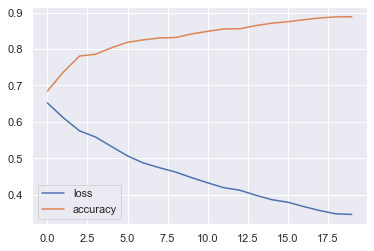

In [29]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [30]:
pred = (model.predict(X_test) > 0.5).astype("int32")
pred

array([[1],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]], dtype=int32)

In [31]:
result = pd.DataFrame()
result['id'] = test['id']
result['target'] = pred
result.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [32]:
result.to_csv('/Users/orucberatturan/Desktop/submission_LSTM.csv',index=False)

### BERT

In [20]:
train_data = train.head(7000).copy()
val_data = train.tail(525).copy()

In [21]:
train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [22]:
(X_train, y_train), (X_val, y_val), preproc = text.texts_from_df(train_df=train_data,
text_column = 'text',label_columns = 'target',val_df = val_data,maxlen = 32,preprocess_mode = 'bert')

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


### Model Creation

In [23]:
model = text.text_classifier(name = 'bert', train_data = (X_train, y_train), preproc= preproc)

Is Multi-Label? False
maxlen is 32
done.


In [24]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_val, y_val), batch_size=16)

### Model Training

In [25]:
learner.fit_onecycle(lr = 2e-5, epochs = 2)
predictor = ktrain.get_predictor(learner.model, preproc)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
438/438 [==============================] - 981s 2s/step - loss: 0.5600 - accuracy: 0.7294 - val_loss: 0.3918 - val_accuracy: 0.8286
Epoch 2/2
438/438 [==============================] - 975s 2s/step - loss: 0.3404 - accuracy: 0.8614 - val_loss: 0.3740 - val_accuracy: 0.8400


In [26]:
result = pd.DataFrame()
result['id'] = test['id']
result['target'] = predictor.predict(test['text'].values)
result['target'] = result['target'].map(lambda x:1 if x=='target' else 0)
result.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [27]:
result.to_csv('submission_bert.csv', index=False)